# Isolation Forest

- Adapted from: https://github.com/Apress/beginning-anomaly-detection-using-python-based-dl/blob/master/Isolation%20Forest%20KDDCUP%201999%20final.ipynb
- Original dataset: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
- Note: used reduced dataset, so only train and test partitions are valid.
- TODO: adapt to spacecraft data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
WORKSPACE_PATH="../"
DATASET_PATH=WORKSPACE_PATH+"data/datasets/"
!tree {DATASET_PATH}

../data/datasets/
└── kddcup
    ├── kddcup.data_10_percent_corrected.csv
    └── kddcup.names

1 directory, 2 files


## Load dataset

In [4]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
len(columns)

42

In [5]:
df = pd.read_csv(DATASET_PATH+"kddcup/kddcup.data_10_percent_corrected.csv",
                 sep=",", names=columns, index_col=None)
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [6]:
df.shape

(494021, 42)

Keep only HTTP service.

In [7]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
columns.remove("service")
df.shape

(64293, 41)

In [8]:
df["label"].value_counts()

normal.       61886
back.          2203
neptune.        192
phf.              4
ipsweep.          3
portsweep.        3
satan.            2
Name: label, dtype: int64

In [9]:
df.head(5)

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,SF,181,5450,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,SF,239,486,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,SF,235,1337,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,SF,219,1337,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,SF,217,2032,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [10]:
# FIXME: encodear todo de a una pasada
for col in df.columns:
    if df[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(df[col])
        df[col] = encoded.transform(df[col])

In [11]:
for f in range(0, 3):
    df = df.iloc[np.random.permutation(len(df))]
    
df2 = df[:500000]
labels = df2["label"]
df_validate = df[500000:]
x_train, x_test, y_train, y_test = train_test_split(df2, labels, test_size = 0.2, random_state = 42)
x_val, y_val = df_validate, df_validate["label"]

In [12]:
x_train.shape, y_train.shape

((51434, 41), (51434,))

In [13]:
isolation_forest = IsolationForest( n_estimators=100, 
                                    max_samples=256, 
                                    contamination=0.1, 
                                    random_state=42)

In [14]:
isolation_forest.fit(x_train)

/home/nhorro/anaconda3/envs/anomaly-env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1, max_samples=256, random_state=42)

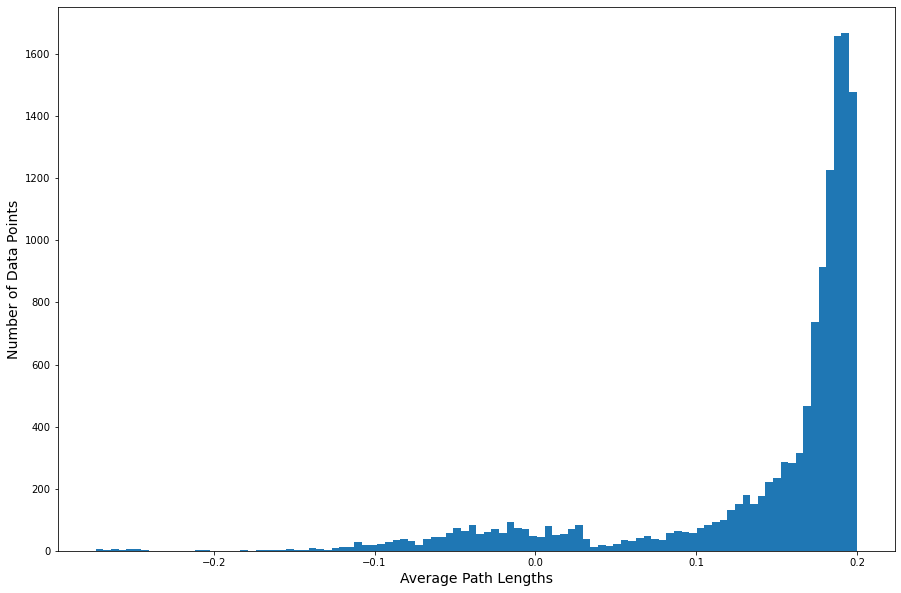

In [22]:
anomaly_scores_test = isolation_forest.decision_function(x_test)
plt.figure(figsize=(15, 10))
plt.hist(anomaly_scores_test, bins=100)
plt.xlabel('Average Path Lengths', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.show()

In [23]:
anomalies_test = anomaly_scores_test > -0.19
matches = y_test == list(encoded.classes_).index("normal.")
auc = roc_auc_score(anomalies_test, matches)
print("AUC: {:.2%}".format (auc))

AUC: 98.28%


In [24]:
print(y_test)

136689    3
37380     3
16623     3
84259     3
29561     3
         ..
85582     3
137809    3
84017     3
106895    3
17015     3
Name: label, Length: 12859, dtype: int64
